# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с нами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Моя задача — провести анализ и подготовить план действий по удержанию клиентов.
А именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  * выделить целевые группы клиентов;
  * предложить меры по снижению оттока;
  * определить другие особенности взаимодействия с клиентами.

### Описание данных
1) Данные клиента за предыдущий до проверки факта оттока месяц:
   * `gender` — пол;
   * `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
   * `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
   * `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
   * `Phone` — наличие контактного телефона;
   * `Age` — возраст;
   * `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

2) Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
   * `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
   * `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
   * `Group_visits` — факт посещения групповых занятий;
   * `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
   * `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
   * `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
   * `Churn` — факт оттока в текущем месяце.



# Оглавление:

1. [Загрузка данных](#step1)  
2. [Исследовательский анализ данных (EDA)](#step2)
3. [Построение модели прогнозирования оттока клиентов](#step3)
4. [Кластеризация клиентов](#step4)
5. [Общий вывод и рекомендации ](#step5)

# 1. Загрузка данных <a id="step1"></a>

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [18]:
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info">
Выше написала код, который убирает красные предупреждения в проекте

In [19]:
data = pd.read_csv('/datasets/gym_churn.csv')
display(data.head())
data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропусков нет. Приведем названия столбцов к нижнему регистру:

In [20]:
data.columns = data.columns.str.lower()
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


# 2. Исследовательский анализ данных (EDA) <a id="step2"></a>

1) Изучим средние значения и стандартные отклонения.

In [21]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


***Вывод:***

* распределение по полу примерно одинаковое;
* практически 85% процентов клиентов живут или работают рядом с фитнес-центром;
* примерно половина клиентов являются сотрудниками компании-партнёра клуба;
* 31% клиентов записались в центр в рамках акции «приведи друга»;
* 90% клиентов оставили свой контактный телефон;
* средняя длительность абонемента - 4,6 месяца;
* 41 % клиентов посещает групповые занятия;
* средний возраст клиента - 29 лет;
* средняя суммарная выручка от других услуг фитнес-центра - 147;
* средний срок до окончания договора - 4,3 месяца;
* среднее время с момента первого обращения в фитнес-центр - 3,7 месяца
* средняя частота посещений в неделю за все время с начала действия абонемента - 1,9
* средняя частота посещений в неделю за предыдущий месяц - 1,8
* доля оттока составляет практически 27%.

2) Посмотрм на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [22]:
data_grouped = data.groupby('churn').agg('mean')
data_grouped.T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


***Вывод:***

* распределение по полу одинаковое;
* клиенты, живущие или работающие в районе фитнес-центра реже попадают в отток;
* сотрудники партнеров клуба реже перестают посещать фитнес-центр;
* клиенты, пришедшие по акции «приведи друга» в два раза реже уходят в отток;
* наличие телефона одинаковое у двух групп;
* средняя длительность абонемента больше у оставшихся клиентов;
* у большинства ушедших клиентов длительность абонемента всего 1 месяц;
* оставшиеся клиенты посещают групповые занятия на 20% чаще;
* средний возраст оставшихся клиентов почти 30 лет, ушедщих в отток - 27;
* средняя суммарная выручка от других услуг фитнес-центра для оставшихся клиентов больше;
* срок до окончания текущего действующего абонемента больше у оставшихся клиентов;
* время с момента первого обращения в фитнес-центр намого больше у оставшихся клиентов;
* средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента так же выше у оставшихся клиентов.

3) Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

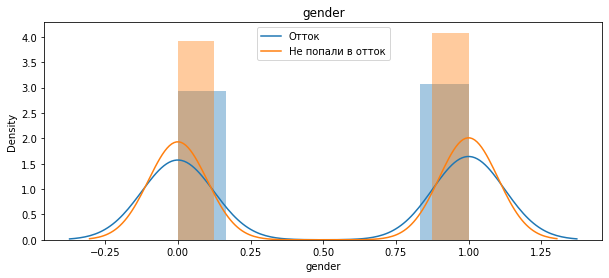

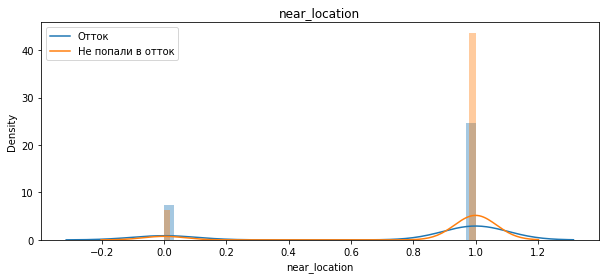

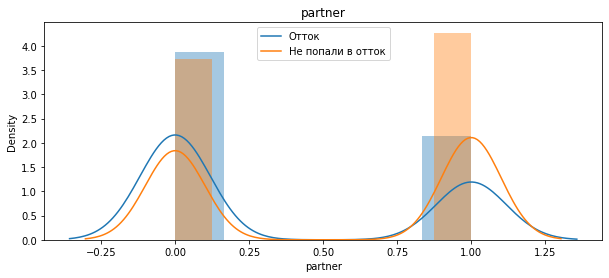

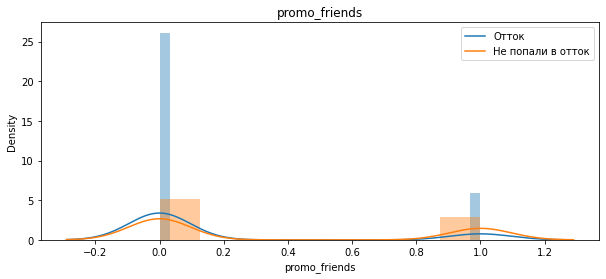

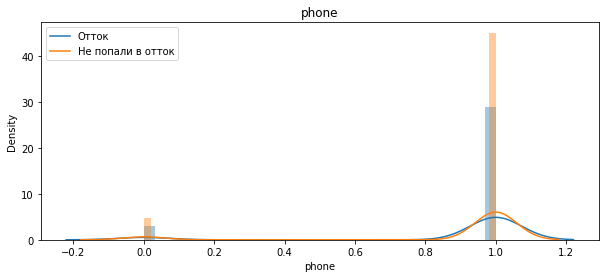

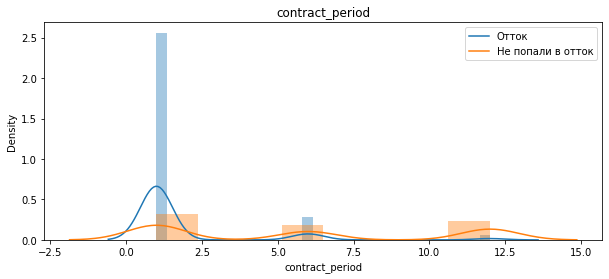

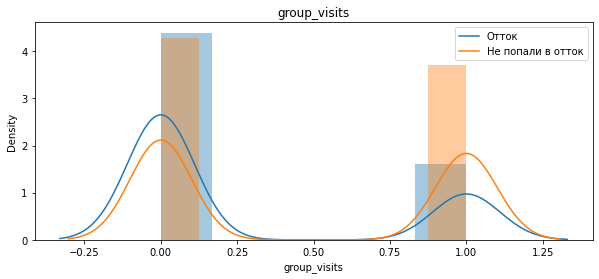

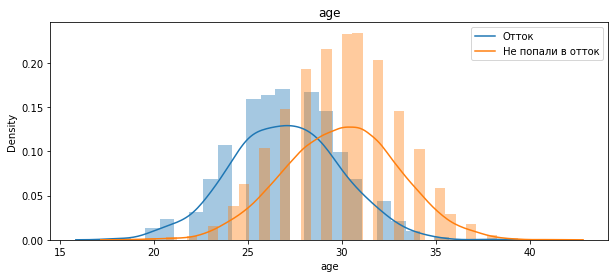

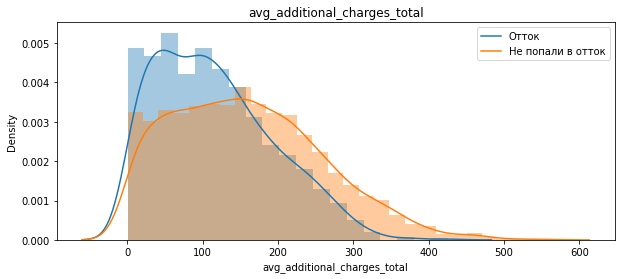

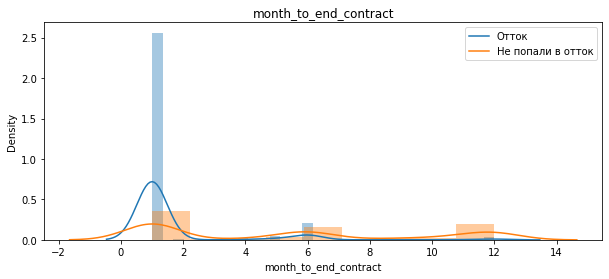

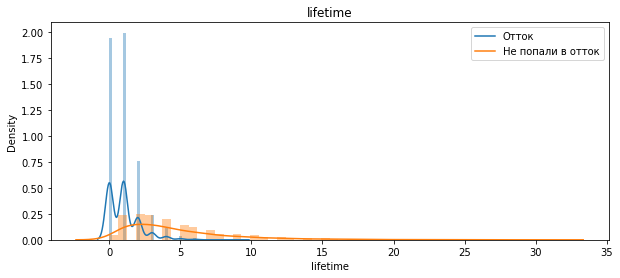

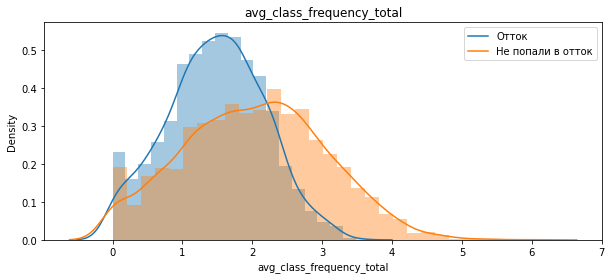

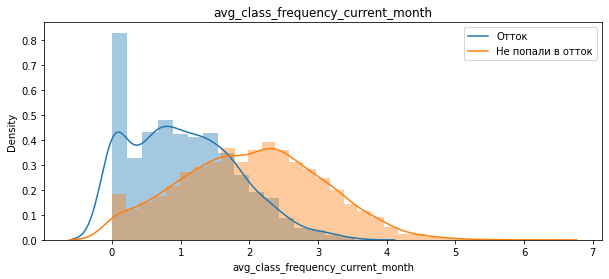

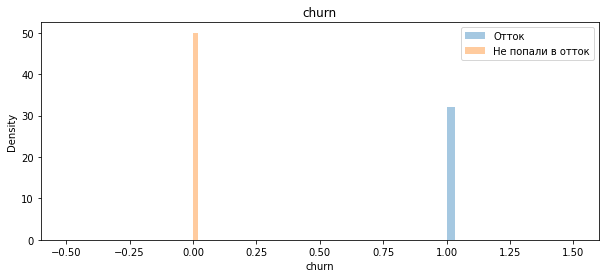

In [23]:
a = data.query('churn == 1')
b = data.query('churn == 0')
for column in data.columns:
    plt.figure(figsize=(10,4)) 
    sns.distplot(a[column])
    sns.distplot(b[column])
    plt.title(column)
    plt.legend(['Отток', 'Не попали в отток'])
    plt.show()

4) Построим и отобразим матрицу корреляций.

<AxesSubplot:>

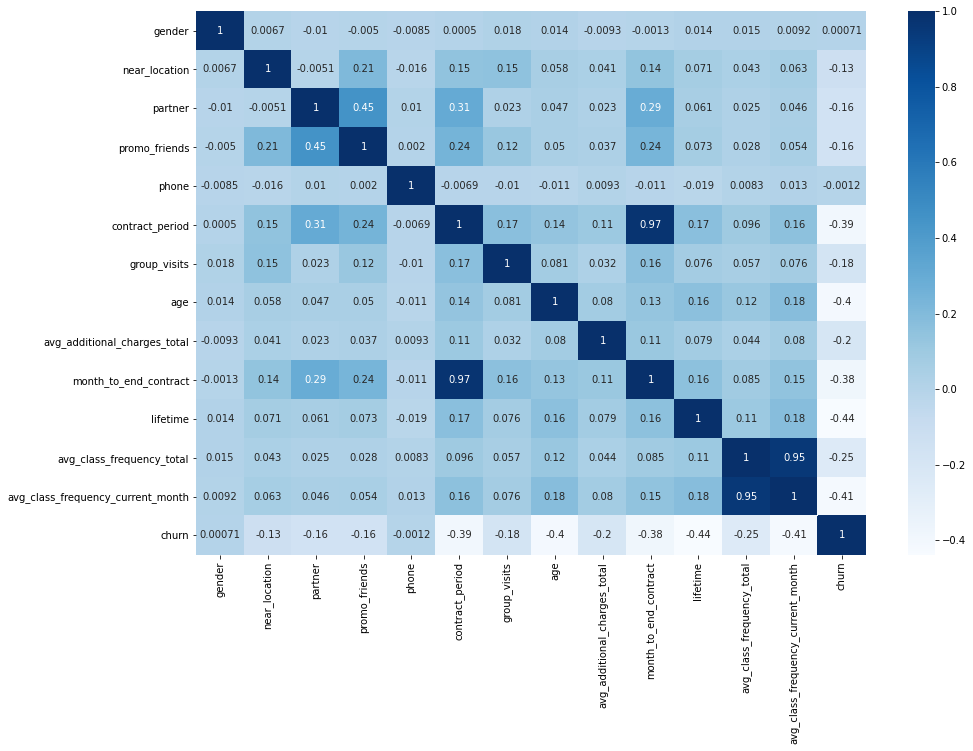

In [24]:
plt.figure(figsize=(15, 10))
sns.heatmap(data=data.corr(), annot=True, cmap='Blues')


***Вывод:***

`month_to_end_contract` и `contract_period` - два мультиколлинеарных признака, так как срок до окончания текущего действующего абонемента напрямую связан с длительностью текущего абонемента. Далее проверим, стоит ли удалять по одному признаку в каждой паре.

`avg_class_frequency_current_month` и `avg_class_frequency_total` так же мультиколлинеарны.

Явной зависимости факта оттока и признаков не обнаружено.

# 3. Построение модели прогнозирования оттока клиентов  <a id="step3">

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.
1) Разобьем данные на обучающую и валидационную выборку.

In [25]:
X = data.drop('churn', axis = 1)
y = data['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

2) Обучим модель на train-выборке двумя способами:
* логистической регрессией,
* случайным лесом.

In [26]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# логистическая регрессия
lr_model = LogisticRegression()
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st) 
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1] 

# случайный лес
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

3) Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. 

In [27]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


***Вывод:***

Модель логистической регрессии показала себя немного лучше, чем модель случайного леса.

Проверим, стоит ли удалять по одному из мультиколлинеарному признаку в паре.

In [29]:
dt = data.drop('month_to_end_contract', axis = 1)
dt = dt.drop('avg_class_frequency_current_month', axis = 1)

X = dt.drop('churn', axis = 1)
y = dt['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# логистическая регрессия
lr_model = LogisticRegression()
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st) 
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1] 

# случайный лес
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81
Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.79
	Recall: 0.76


***Вывод:***

Модель стала работать немного хуже после удаления признаков. Поэтому далее будем работать с полными данными.

# 4. Кластеризация клиентов <a id="step4">

1) Построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму.

In [ ]:
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('\n Иерархическая кластеризация', fontsize=15)
plt.show()
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_st)
data['cluster_km'] = labels

***Вывод:***

На графике явно выделено 4 кластера. По заданию примем число кластеров за `n=5`.

2) Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [13]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_st)

data['cluster_km'] = labels

3) Посмотрим на средние значения признаков для кластеров.

In [14]:
data.groupby(['cluster_km']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


***Вывод:***

Кластер 0:

* отток самый низкий - всего 3%;
* 96% клиентов живут или работают в районе финтнес-центра;
* 78% клиентов сотрудники партнерских кампаний;
* 57% пришли по акции;
* наибольшая длительность текущего абонемента среди всех кластеров;
* самое высокое посещение групповых занятьй среди всех кластеров - 54%.

Кластер 1:

* отток 26%;
* 86% клиентов живут или работают в районе финтнес-центра;
* не указан мобильный телефон;
* заключают контракт в среднем на 4,8 месяца.

Кластер 2:

* отток 44%;
* никто из клиентов не живет и не работает в районе финтнес-центра;
* всего лишь 8% клиентов этого кластера пришли по акции;
* заключают контракт в среднем на 2,4 месяца;
* реже остальных кластеров посещают групповые занятия.


Кластер 3:

* отток самый высокий - 51%;
* все клиенты кластера живут или работают в районе финтнес-центра; 
* заключают контракт в среднем на 1,9 месяца - самый низкий показатель по кластерам;
* наиболее низкая посещаемость за месяц и в за весь период.

Кластер 4:

* отток 7 %
* 98% клиентов живут или работают в районе финтнес-центра;
* самая высокая посещаемость за месяц и за весь перид - 2,9;
* заключают контракт в среднем на 2,7 месяца.

4) Построим распределения признаков для кластеров.

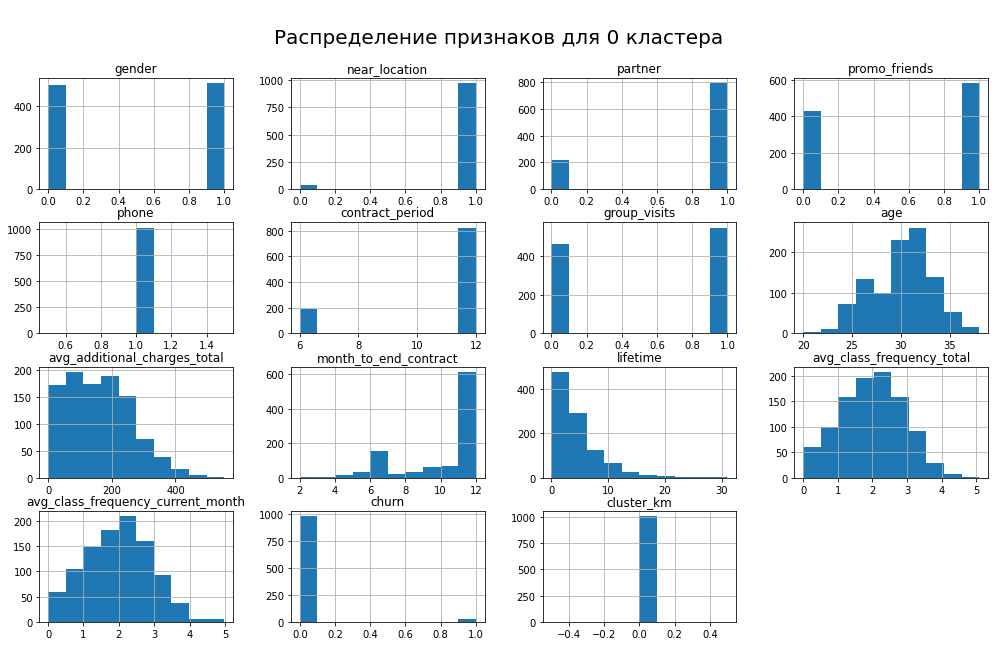

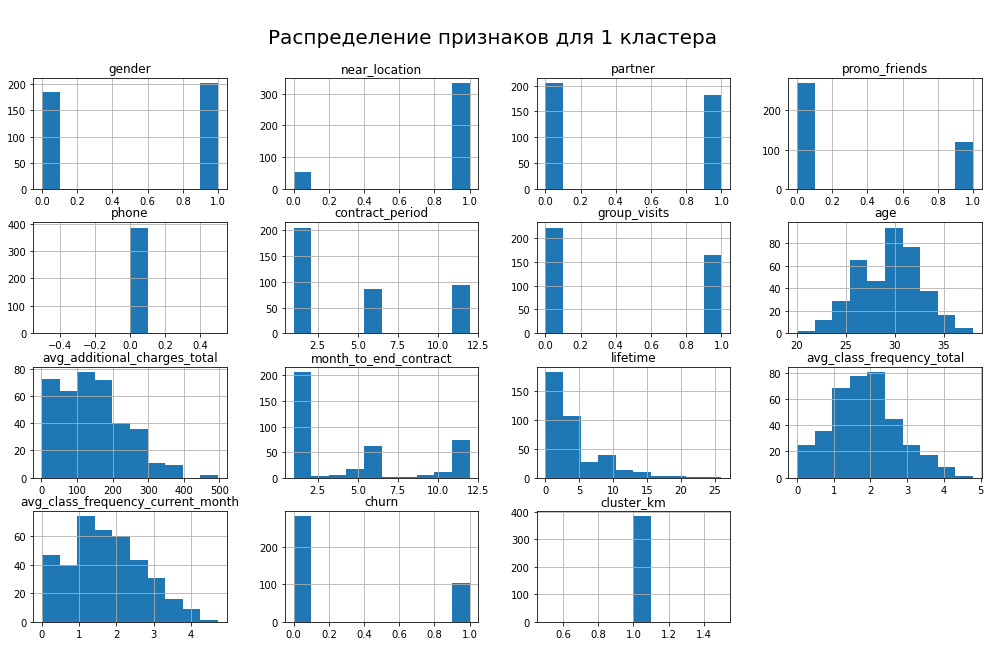

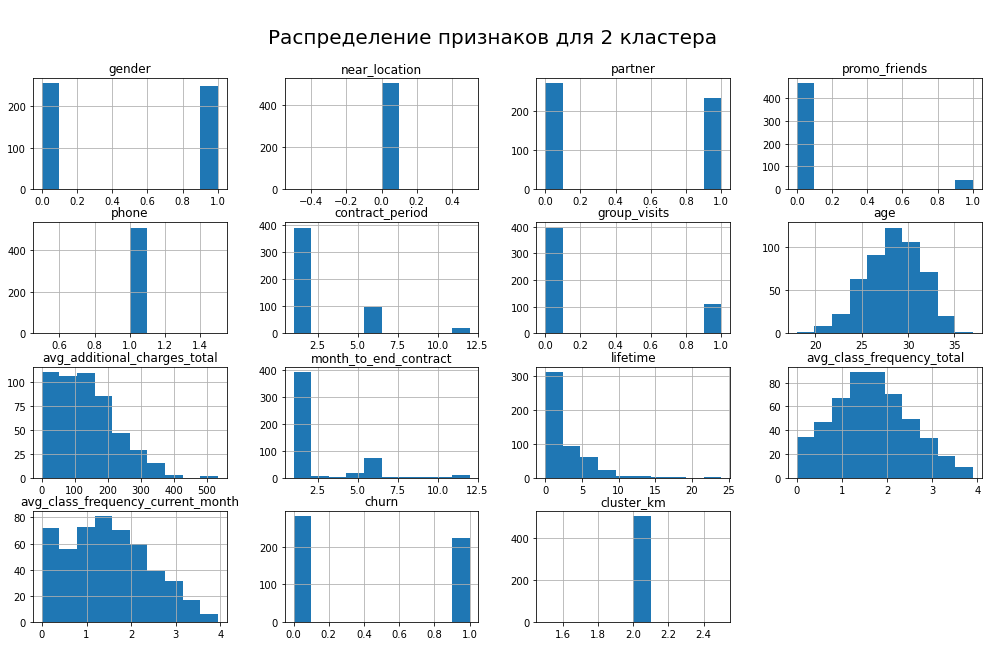

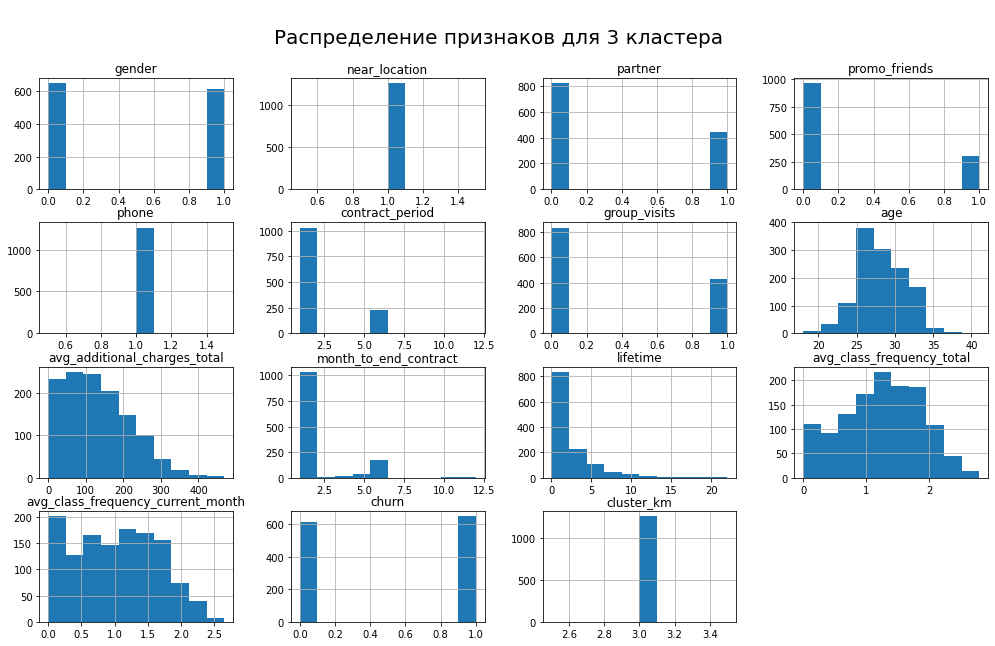

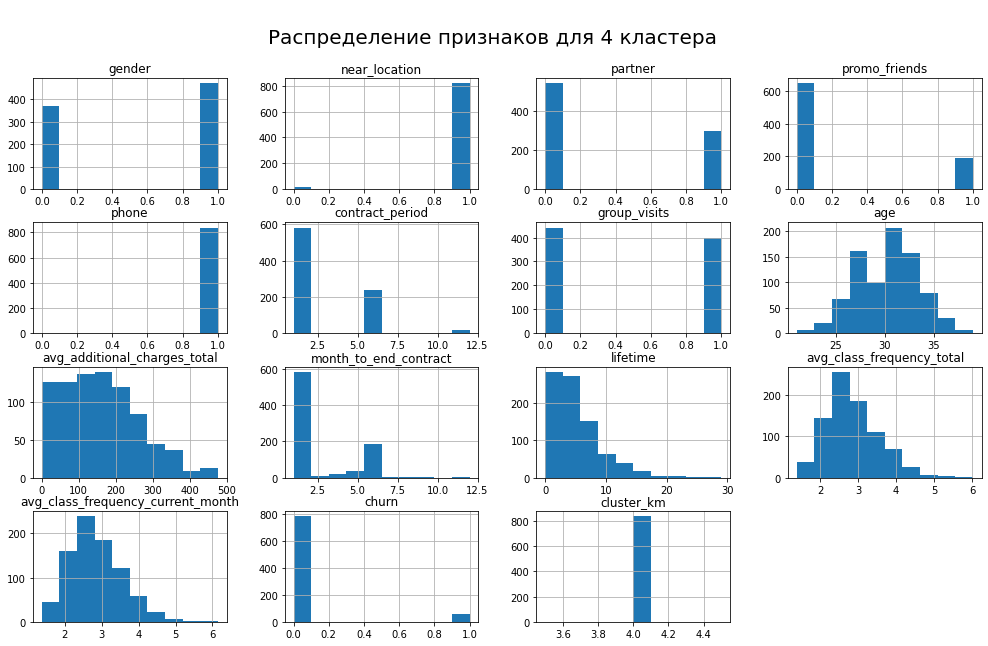

In [15]:
def bar(i):
    data[data['cluster_km'] == i].hist(figsize=(17,10))
    plt.suptitle('\nРаспределение признаков для {} кластера'.format(i), fontsize = 20)
    plt.show()
bar(0)
bar(1)
bar(2)
bar(3)
bar(4)

***Вывод:***

Графики наглядно демонстрируют вывод из предыдущего пункта.

5) Для каждого полученного кластера посчитаем долю оттока.

In [16]:
part = data.pivot_table(index='cluster_km', columns='churn', values='age', aggfunc='count')
part['part'] = part[1] / part[0]
part

churn,0,1,part
cluster_km,,,
0,982,28,0.028513
1,282,103,0.365248
2,281,224,0.797153
3,613,649,1.058728
4,781,57,0.072983


***Вывод:***

Наиболее склонны к оттоку кластеры 3 и 2, как и было выяснено ранее.

# 5. Общий вывод и рекомендации <a id="step5">

**Исходя из анализа предоставленных данных можно сделать следующие выводы:**
    
* Распределение по полу примерно одинаковое;
* Практически 85% процентов клиентов живут или работают рядом с фитнес-центром;
* Примерно половина клиентов являются сотрудниками компании-партнёра клуба;
* 31% клиентов записались в центр в рамках акции «приведи друга»;
* 90% клиентов оставили свой контактный телефон;
* Средняя длительность абонемента - 4,6 месяца;
* 41 % клиентов посещает групповые занятия;
* Средний возраст клиента - 29 лет;
* Средняя суммарная выручка от других услуг фитнес-центра - 147;
* Средний срок до окончания договора - 4,3 месяца;
* Среднее время с момента первого обращения в фитнес-центр - 3,7 месяца
* Средняя частота посещений в неделю за все время с начала действия абонемента - 1,9
* Средняя частота посещений в неделю за предыдущий месяц - 1,8
* Доля оттока составляет практически 27%.

**Выводы на основе разбиения клиентов на две группы — тех, кто ушел в отток и тех, кто остался:**

* Распределение по полу одинаковое;
* Клиенты, живущие или работающие в районе фитнес-центра реже попадают в отток;
* Сотрудники партнеров клуба реже перестают посещать фитнес-центр;
* Клиенты, пришедшие по акции «приведи друга» в два раза реже уходят в отток;
* Наличие телефона одинаковое у двух групп;
* Средняя длительность абонемента больше у оставшихся клиентов;
* У большинства ушедших клиентов длительность абонемента всего 1 месяц;
* Оставшиеся клиенты посещают групповые занятия на 20% чаще;
* Средний возраст оставшихся клиентов почти 30 лет, ушедщих в отток - 27;
* Средняя суммарная выручка от других услуг фитнес-центра для оставшихся клиентов больше;
* Срок до окончания текущего действующего абонемента больше у оставшихся клиентов;
* Время с момента первого обращения в фитнес-центр намого больше у оставшихся клиентов;
* Средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента так же выше у оставшихся клиентов.

**Выводы на основе разбиения клиентов на кластеры:**

Кластер 0:

* отток самый низкий - всего 3%;
* 96% клиентов живут или работают в районе финтнес-центра;
* 78% клиентов сотрудники партнерских кампаний;
* 57% пришли по акции;
* наибольшая длительность текущего абонемента среди всех кластеров;
* самое высокое посещение групповых занятьй среди всех кластеров - 54%.

Кластер 1:

* отток 26%;
* 86% клиентов живут или работают в районе финтнес-центра;
* не указан мобильный телефон;
* заключают контракт в среднем на 4,8 месяца.

Кластер 2:

* отток 44%;
* никто из клиентов не живет и не работает в районе финтнес-центра;
* всего лишь 8% клиентов этого кластера пришли по акции;
* заключают контракт в среднем на 2,4 месяца;
* реже остальных кластеров посещают групповые занятия.


Кластер 3:

* отток самый высокий - 51%;
* все клиенты кластера живут или работают в районе финтнес-центра; 
* заключают контракт в среднем на 1,9 месяца - самый низкий показатель по кластерам;
* наиболее низкая посещаемость за месяц и в за весь период.

Кластер 4:

* отток 7 %
* 98% клиентов живут или работают в районе финтнес-центра;
* самая высокая посещаемость за месяц и за весь перид - 2,9;
* заключают контракт в среднем на 2,7 месяца.

**Рекомендации:**

Сильнее всего на отток влияет долгосрочность приобретенного абонемента - чем дольше его действие, тем меньше вероятность того, что клиент попадет в отток. Советую обратить внимание на клиентов с недолгосрочным абонементом - они есть группа риска.

На основе этих выводов можно смело прогнозировать вероятность оттока клиентов в дальнейшем.